In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Check Your Environment and Version of Training Modules**

In [1]:
import tensorflow as tf
import keras
import platform
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Platform: Windows-10-10.0.18362-SP0
Tensorflow version: 2.2.0
Keras version: 2.4.3


## **Load TensorBoard and create logfiles**

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from datetime import datetime
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### change tensorflow version to 2.2.0

In [9]:
# ! pip uninstall tensorflow
# ! pip install tensorflow==2.2.0
! clear
! pip list | grep tensorflow

'clear' 不是內部或外部命令、可執行的程式或批次檔。


tensorflow             2.2.0
tensorflow-estimator   2.2.0


## **Split Data**

In [3]:
_COLAB = False
import os
# import glob
# import random
# import shutil
os.chdir('/content/drive/MyDrive/Colab_Notebooks/2020DL_hw2/Datasets' if _COLAB else 'Datasets/Q5_Image')
# print(os.getcwd())
# if os.path.isdir('train/dog') is False:
# if True:
#     os.makedirs('train/dog')
#     os.makedirs('train/cat')
#     os.makedirs('valid/dog')
#     os.makedirs('valid/cat')
#     os.makedirs('test/dog')
#     os.makedirs('test/cat')
#     tot_num = len(glob.glob('Dog/*.jpg'))
#     train_num = int(tot_num * 0.6)
#     valid_num = int(tot_num * 0.2)
#     test_num = tot_num - train_num - valid_num
#     print('total data: {}'.format(tot_num))
#     print('pick {} as training dataset.'.format(train_num))
#     print('pick {} as valid dataset.'.format(valid_num))
#     print('pick {} as testing dataset.'.format(test_num))
#     for c in random.sample(glob.glob('Cat/*.jpg'), train_num):
#         shutil.move(c, 'train/cat')
#     print('train/cat complete.')
#     for c in random.sample(glob.glob('Cat/*.jpg'), valid_num):
#         shutil.move(c, 'valid/cat')
#     print('valid/cat complete.')
#     for c in random.sample(glob.glob('Cat/*.jpg'), test_num):
#         shutil.move(c, 'test/cat')
#     print('test/cat complete.')
#     for c in random.sample(glob.glob('Dog/*.jpg'), train_num):
#         shutil.move(c, 'train/dog')
#     print('train/dog complete.')
#     for c in random.sample(glob.glob('Dog/*.jpg'), valid_num):
#         shutil.move(c, 'valid/dog')
#     print('train/dog complete.')
#     for c in random.sample(glob.glob('Dog/*.jpg'), test_num):
#         shutil.move(c, 'test/dog')
#     print('test/dog complete.')
#     print('Splitting data complete.')
# else:
#     print('Data has already been splitted')
if _COLAB is False:
  os.chdir('../../')
print(os.getcwd())

C:\2020-NCKU_DL\hw2


## **Data Preprocessing**
### **Load Data from drive**
[ASIRRA download link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
root_path = '/content/drive/MyDrive/Colab_Notebooks/2020DL_hw2/Datasets'
train_path = '/train'  if _COLAB else 'Datasets/Q5_Image/train'
valid_path = '/valid'  if _COLAB else 'Datasets/Q5_Image/valid'
test_path = '/test'    if _COLAB else 'Datasets/Q5_Image/test'
if _COLAB is True:
    train_path = root_path + train_path
    valid_path = root_path + valid_path
    test_path = root_path + test_path
print(train_path)
print(valid_path)
print(test_path)
# Define classes
clss = ['cat', 'dog']
NUM_CLASSES = len(clss)
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16

# Create batches
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=IMAGE_SIZE, 
                         classes=clss, batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=IMAGE_SIZE,
                         classes=clss, batch_size=BATCH_SIZE)
# test_batches = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
#     .flow_from_directory(directory=test_path, target_size=IMAGE_SIZE,
#                          classes=clss, batch_size=BATCH_SIZE, shuffle=False)

# Confirm batches status
assert train_batches.n == 14985, 'error train_batches.n={}'.format(train_batches.n)
assert valid_batches.n == 4991, 'error valid_batches.n={}'.format(valid_batches.n)
# assert test_batches.n == 5000, 'error test_batches.n={}'.format(test_batches.n)

# Show the codes corresponding to the type of class
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
imgs, labels = next(train_batches)

# Image preview function
def plotImages(images_arr):
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show one batch of data
# plotImages(imgs)
# print(labels)

Datasets/Q5_Image/train
Datasets/Q5_Image/valid
Datasets/Q5_Image/test
Found 14985 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.
Class #0 = cat
Class #1 = dog


## **Create ResNet50 model**
### Remind that...
1. First input layer must be equal to the input data shape
2. Last output layer number must be 2 (output data #categories)


In [5]:
import keras.backend as K
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam

# Use well-trained ResNet50 model
# Discard the top layer of ResNet50: fully connected layers
K.clear_session()
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
# add Flatten and DropOut layer
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)

# Customize output layer
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# Set freeze layers and training layers
FREEZE_LAYERS = 2
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

 
# Set Configurations (loss function, learning rate)
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
net_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## **Start Training**

In [ ]:
print('train_batches.samples: ', train_batches.samples)
print('valid_batches.samples: ', valid_batches.samples)
NUM_EPOCHS = 5
hist = net_final.fit(train_batches,
                    # steps_per_epoch = 10,
                    #  steps_per_epoch = train_batches.samples,    #BATCH_SIZE
                     validation_data = valid_batches,
                    #  validation_steps = valid_batches.samples,   #BATCH_SIZE
                     epochs = NUM_EPOCHS)

train_batches.samples:  14985
valid_batches.samples:  4991
Epoch 1/5
937/937 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.8342

## **Evaluate Test Data**

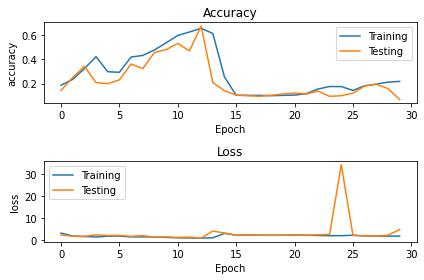

In [ ]:
import numpy as np
# Evaluate test data (output accuracy result)
# model.evaluate(x_test, y_test)
import matplotlib.pyplot as plt
fig = plt.figure('Accuracy')
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Training', 'Testing'])
plt.tight_layout()

## **Save Your Model and History**
  1. For **model** use **save()** method
  2. For **history** use **json file** format

    i. **hist.history** including **acc hist.** and **loss hist.**

    ii. **his.params** including **batch_size**


In [ ]:
# Create a time stamp
import pytz

timezone = pytz.timezone("Asia/Taipei")
os_time = datetime.now()
local_time = timezone.localize(os_time)
time_stamp = local_time.strftime("%m-%d_%H_%M")
time_stamp

'11-12_06_42'

In [ ]:
# Save the model
model_filename = 'vgg16_cifar10_'+time_stamp+'.h5'
model.save(model_filename)
print('Successfully save \'' + model_filename + '\'')
 
# Save Training history as json file
import json
merge_hist = {**hist.history, **hist.params}
j = json.dumps(merge_hist)
hist_filename = 'vgg16_cifar10_history_'+time_stamp+'.json'
with open(hist_filename, 'w') as file:
  file.write(j)
  print('Successfully write \'' + hist_filename + '\'')

Successfully save 'vgg16_cifar10_11-12_06_42.h5'
Successfully write 'vgg16_cifar10_history_11-12_06_42.json'


### copy to google drive by console

In [ ]:
! cp vgg16_cifar10_11-12_06_42.h5 /content/drive/My\ Drive/Colab\ Notebooks
! cp vgg16_cifar10_history_11-12_06_42.json /content/drive/My\ Drive/Colab\ Notebooks

## **Reload the trained model and history from disk**

### Q5.3 show the model strucure

In [ ]:
# Load model from disk
from tensorflow.keras.models import load_model
new_model = load_model(model_filename)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

In [ ]:
# Load history file from disk
with open(hist_filename) as file:
  hist = json.load(file)
  print('Successfully load \'' + hist_filename + '\'.')

Successfully load 'vgg16_cifar10_history_11-12_02_54.json'.


### Q5.2 show hyperparameters

In [ ]:
# Get Hyperparameters
import keras.backend as K
import numpy as np
print('batch size:', int(np.ceil(x_train.shape[0]/hist['steps'])))
print('learning rate:', K.eval(model.optimizer.lr))
print('optimizer:', new_model.optimizer.get_config()['name'])

batch size: 1563
learning rate: 0.01
optimizer: SGD


### Q5.4 plot the training diagram

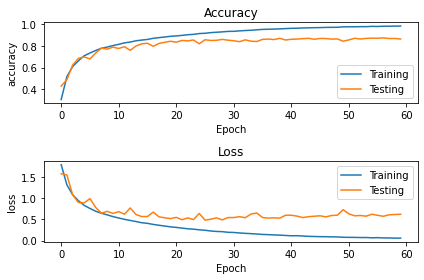

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure('Accuracy')
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Training', 'Testing'])
plt.tight_layout()

### Q5.5 show prediction result

In [ ]:
# Demo: get output layer output
pred_res = new_model.predict(np.array([x_test[0]]))
for i in pred_res:
    print(i)

[1.4547784e-06 9.2158285e-07 2.0974187e-05 9.9879503e-01 3.4392185e-06
 2.7781664e-04 8.8452175e-04 1.1039663e-05 3.0058538e-06 1.7891437e-06]


Test Image Index: 1848


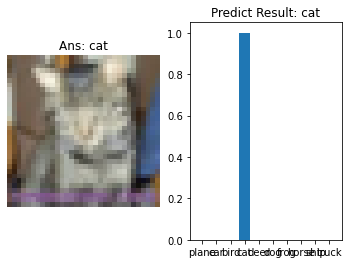

In [ ]:
# plot image
test_ind = np.random.randint(0, x_test.shape[0]-1)
plt.subplot(1, 2, 1)
plt.imshow(x_test_org[test_ind])
plt.axis('off')
print('Test Image Index:', test_ind)
plt.title('Ans: ' + label[y_test_org[test_ind][0]])
 
# plot predict result bar chart
plt.subplot(1, 2, 2)
y_predict = new_model.predict(np.array([x_test[test_ind]]))
max_predict = np.argmax(y_predict[0])
title = 'Predict Result: '+ label[max_predict]
plt.title(title)
plt.bar(label, y_predict[0])
plt.show()

## **Download files from Google cotlab**
### large files may fail to download :(

In [ ]:
# Download Trained model and training history
from google.colab import files
print('time_stamp:', time_stamp)
files.download('vgg16_cifar10_'+time_stamp+'.h5')

time_stamp: 11-11_13_28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('vgg16_cifar10_history_'+time_stamp+'.json')